In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from lattice_utils import (
    MultiFileDataset,
    BinFileDataset,
    xy_hamiltonian,
    corr_2d,
    deformed_corr_2d,
    reweight,
    plot_tensor_grid,
    plot_hists,
)
from models import UNet, Conv1Layer
from engines import train

In [2]:
kernel_size = 21
lat_size = 128

train_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/train")
val_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/val")

min_sep_1layer = lat_size // 4 - 1

train_single_file_ds = BinFileDataset(
    folder="L_128/U-Net/train",
    fname="L=128_cluster_T=0.8000_configs.bin",
    seps=(min_sep_1layer, min_sep_1layer),
    random_seps=True,
)

val_single_file_ds = BinFileDataset(
    folder="L_128/U-Net/val",
    fname="L=128_cluster_T=0.8000_configs.bin",
    seps=(min_sep_1layer, min_sep_1layer),
    random_seps=True,
)

In [3]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.6.0+rocm6.4.1.git1ded221d
AMD Radeon™ RX 7700S


In [4]:
conv1layer = Conv1Layer(lat_size=lat_size, kernel_size=kernel_size)
conv1layer.to(device)

Conv1Layer(
  (conv): Conv2d(1, 1, kernel_size=(21, 21), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)

In [5]:
optim = Adam(conv1layer.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optim, 30, 1e-5)

loader = DataLoader(train_single_file_ds, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_single_file_ds, batch_size=64, shuffle=False, pin_memory=True)

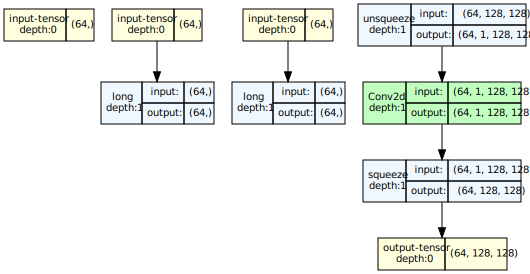

In [6]:
from torchview import draw_graph

conv1layer.to("cpu")

graph = draw_graph(conv1layer, input_data=next(iter(loader))[1:])
graph.visual_graph

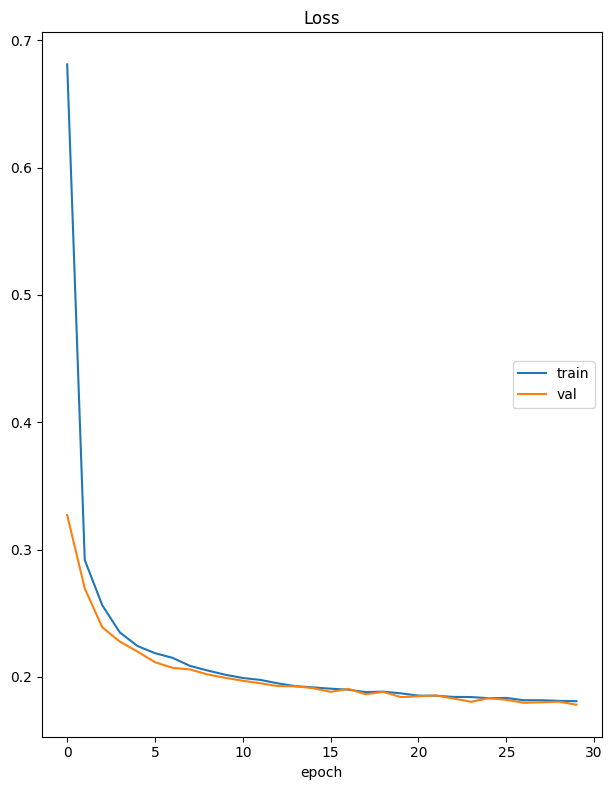

Loss
	train            	 (min:    0.181, max:    0.681, cur:    0.181)
	val              	 (min:    0.178, max:    0.327, cur:    0.178)


In [7]:
conv1layer.to(device)

train(
    model=conv1layer,
    loader=loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=30,
    device=device,
    val_loader=val_loader,
)

In [27]:
torch.save(conv1layer.state_dict(), "conv1layer_128.pth")

In [8]:
conv1layer.eval()

initial = []
deformed = []

with torch.no_grad():
    for batch, inputs in enumerate(loader):
        inputs = tuple(input.to(device) for input in inputs)
        lats, temps, x, y = inputs
        shift_fields = conv1layer(temps, x, y)
        deformed.append(deformed_corr_2d(lats, temps, shift_fields, x, y))
        initial.append(corr_2d(lats, x, y))

initial = torch.cat(initial, dim=0).cpu()
deformed = torch.cat(deformed, dim=0).cpu()

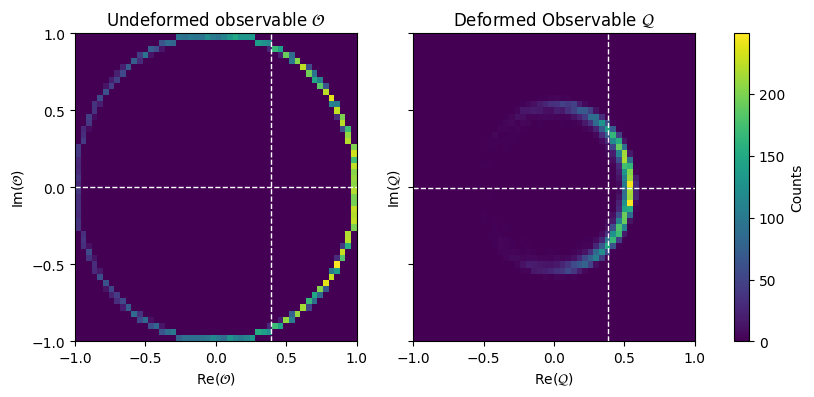

In [9]:
plot_hists(initial, deformed)

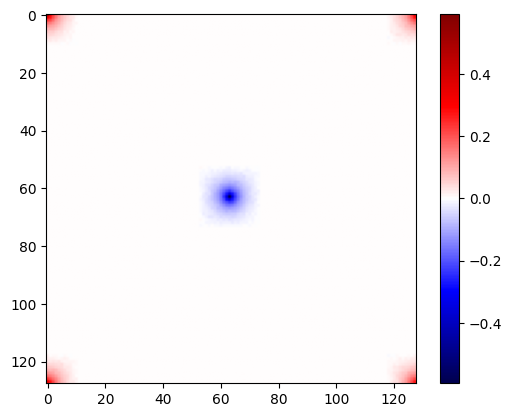

In [10]:
plt.imshow(
    conv1layer.cpu()(
        torch.tensor([0.8], dtype=torch.float32),
        torch.tensor([63], dtype=torch.float32),
        torch.tensor([63], dtype=torch.float32),
    )
    .detach()
    .squeeze(0)
    .numpy(),
    cmap="seismic",
)
plt.colorbar()

**U-Net architecture for temperation and separation generalization**

Separation allowed to vary over the full lattice, and a set temperatures is used for training

Consider boltzmann reweighting to interpolate between temperatures?

Loss function:
$$\frac{1}{L^2}\sum_{\mathbf{x}\in\Lambda}\int_{t_0}^{t_1}dt\,\rho(t) \cdot \mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right]$$

$$\mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right] = \left[\mathrm{Re}\left\langle \mathcal{Q(\mathbf{x},t)} \right\rangle\right]^2 + \lambda\sum_{\langle \mathbf{a}\,\mathbf{b} \rangle}\left|\Delta(\mathbf{a},t)-\Delta(\mathbf{b},t)\right|^2$$

$$\mathcal{Q}(\mathbf{x},t)=\exp\left[i(\tilde{\theta}(\mathbf{x},t) - \tilde{\theta}(\mathbf{0},t))\right]\cdot\exp\left[{-\beta(H(\tilde{\Omega})-H(\Omega))}\right]$$

$$\Omega=\left\{\theta(\mathbf{x}) | \mathbf{x}\in \Lambda\right\},\, \tilde{\theta}(\mathbf{x}) = \theta(\mathbf{x},t) + i\Delta(\mathbf{x,t})$$

With $\rho(t)$ some probability density that has support over $[t_0,t_1]$. Currently using a uniform sampling in $\beta$ rather than $t$, which amounts to the change of variables $d\beta=-dT/T^2$

The addition $\lambda$ regularization term penalizes heavy gradients in the shift field to promote stability. This is not motivated physically as much as it is from a machine learning point of view

In [17]:
unet = UNet(lat_size=128, min_size=4)

In [18]:
from torch.utils.data import WeightedRandomSampler

weights = reweight(
    torch.stack([train_multi_file_ds[i][1] for i in range(len(train_multi_file_ds))]).detach().numpy(),
    dist=lambda x: x**-2,
)

sampler = WeightedRandomSampler(weights, num_samples=len(train_multi_file_ds), replacement=True)

In [19]:
weights

array([83.67347 , 83.67347 , 83.67347 , ..., 33.884296, 33.884296,
       33.884296], shape=(738000,), dtype=float32)

In [20]:
loader = DataLoader(train_multi_file_ds, batch_size=64, pin_memory=True, sampler=sampler)
val_loader = DataLoader(val_multi_file_ds, batch_size=256, shuffle=False, pin_memory=True)

optim = Adam(unet.parameters(), lr=1e-3)
scheduler = CosineAnnealingWarmRestarts(optim, 2500, eta_min=1e-5)

In [21]:
from torchinfo import summary

summary(unet.cpu(), input_data=next(iter(loader))[1:])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [64, 128, 128]            --
├─ModuleList: 1-21                       --                        (recursive)
│    └─Conv2d: 2-1                       [64, 2, 128, 128]         20
├─ModuleList: 1-22                       --                        (recursive)
│    └─Sequential: 2-2                   [64, 4]                   --
│    │    └─Linear: 3-1                  [64, 2]                   4
│    │    └─SiLU: 3-2                    [64, 2]                   --
│    │    └─Linear: 3-3                  [64, 4]                   12
│    │    └─SiLU: 3-4                    [64, 4]                   --
├─ModuleList: 1-38                       --                        (recursive)
│    └─Conv2d: 2-3                       [64, 2, 128, 128]         38
├─MaxPool2d: 1-4                         [64, 2, 64, 64]           --
├─ModuleList: 1-21                       --                

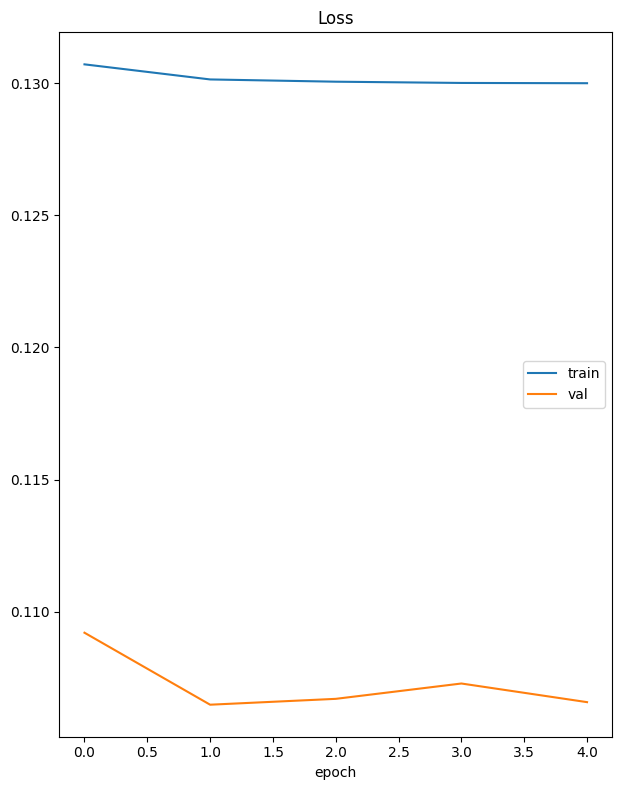

Loss
	train            	 (min:    0.130, max:    0.131, cur:    0.130)
	val              	 (min:    0.106, max:    0.109, cur:    0.107)
Batch 1/11532, Loss: 0.1163
Batch 26/11532, Loss: 0.1245
Batch 51/11532, Loss: 0.1238
Batch 76/11532, Loss: 0.1237
Batch 101/11532, Loss: 0.1220
Batch 126/11532, Loss: 0.1267
Batch 151/11532, Loss: 0.1121
Batch 176/11532, Loss: 0.1205
Batch 201/11532, Loss: 0.1281
Batch 226/11532, Loss: 0.1279
Batch 251/11532, Loss: 0.1310
Batch 276/11532, Loss: 0.1245
Batch 301/11532, Loss: 0.1371
Batch 326/11532, Loss: 0.1292
Batch 351/11532, Loss: 0.1274
Batch 376/11532, Loss: 0.1373
Batch 401/11532, Loss: 0.1014
Batch 426/11532, Loss: 0.1496
Batch 451/11532, Loss: 0.1204
Batch 476/11532, Loss: 0.1352
Batch 501/11532, Loss: 0.1486
Batch 526/11532, Loss: 0.1291
Batch 551/11532, Loss: 0.1282
Batch 576/11532, Loss: 0.1156
Batch 601/11532, Loss: 0.1296
Batch 626/11532, Loss: 0.1294
Batch 651/11532, Loss: 0.1288
Batch 676/11532, Loss: 0.1322
Batch 701/11532, Loss: 0.126

KeyboardInterrupt: 

In [23]:
unet.to(device)

train(
    model=unet,
    loader=loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=20,
    device=device,
    val_loader=val_loader,
)

In [24]:
torch.save(unet.state_dict(), "unet_state_dict_128.pth")